# Evaluating Final Model on 2019 Test Data

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os
import pickle
from timeit import default_timer as timer
from datetime import date, datetime, timezone
from dateutil.relativedelta import relativedelta
from dateutil import parser
import traceback

from dogs import modelling

In [2]:
DATA_DIR = '../data'

In [3]:
# read data
modelling_data = pd.read_csv(os.path.join(DATA_DIR, 'modelling_data_25days.csv'), index_col = 'race_id')
modelling_data

,date_time,winning_box,benchmark,min_time_1,min_time_2,min_time_3,min_time_4,min_time_5,min_time_6,avg_time_1,...,pcnt_place_3,pcnt_place_4,pcnt_place_5,pcnt_place_6,pcnt_show_1,pcnt_show_2,pcnt_show_3,pcnt_show_4,pcnt_show_5,pcnt_show_6
race_id,,,,,,,,,,,,,,,,,,,,,
2539774,2008-11-15 20:58:00+00:00,5,2,29.08,28.95,29.13,28.89,28.76,29.74,29.176667,...,0.5,0.500000,1.0,0.000000,0.666667,1.000000,0.500000,0.500000,1.0,0.000000
2539775,2008-11-15 21:14:00+00:00,2,1,29.11,29.10,29.25,29.13,29.10,29.02,29.120000,...,0.0,0.500000,0.0,0.333333,0.333333,1.000000,0.666667,0.500000,0.0,0.666667
2851623,2010-08-30 10:07:00+00:00,4,5,30.02,29.95,30.74,30.23,29.84,29.78,30.415000,...,0.0,0.000000,0.5,0.333333,0.500000,0.000000,0.000000,0.000000,0.5,1.000000
2851624,2010-08-30 10:23:00+00:00,3,4,29.99,30.11,30.11,29.53,29.71,29.71,30.117500,...,0.0,0.666667,1.0,0.666667,0.000000,0.000000,0.000000,0.666667,1.0,0.666667
2539777,2008-11-15 21:45:00+00:00,0,1,NaN,NaN,31.08,NaN,30.32,29.47,NaN,...,0.0,NaN,0.0,1.000000,NaN,NaN,0.000000,NaN,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539765,2008-11-15 18:38:00+00:00,0,5,28.85,29.00,29.13,29.10,29.50,28.87,28.865000,...,0.5,0.500000,0.0,0.333333,1.000000,0.666667,0.500000,0.750000,0.0,0.333333
2539766,2008-11-15 18:56:00+00:00,3,2,28.89,29.44,29.55,29.43,29.67,29.04,29.193333,...,0.0,0.000000,0.0,0.500000,1.000000,0.000000,0.000000,0.000000,0.0,0.500000
2539767,2008-11-15 19:11:00+00:00,5,5,29.65,29.71,30.10,29.52,29.95,29.56,29.890000,...,0.5,0.500000,0.0,0.333333,0.333333,0.500000,0.750000,0.500000,0.0,0.666667


We drop the pcnt_place variables as we found them detrimental to performance in the feature_importance notebook

In [4]:
drop_cols = list(modelling_data.filter(regex = 'pcnt_place'))
drop_cols

['pcnt_place_1',
 'pcnt_place_2',
 'pcnt_place_3',
 'pcnt_place_4',
 'pcnt_place_5',
 'pcnt_place_6']

Next we evalue the modelling process using the settings we identified during out experiments. We perform this test once on data that we haven't seen before (2019) to get an honest assessment of the models likely performance.

data starts at 2002-01-03 18:09:00+00:00
Building model for 2019:1
Train shape:  (26990, 42)
Test shape:  (244, 42)
The following columns will be used in the modelling 
 ['min_time_1' 'min_time_2' 'min_time_3' 'min_time_4' 'min_time_5'
 'min_time_6' 'avg_time_1' 'avg_time_2' 'avg_time_3' 'avg_time_4'
 'avg_time_5' 'avg_time_6' 'min_stime_1' 'min_stime_2' 'min_stime_3'
 'min_stime_4' 'min_stime_5' 'min_stime_6' 'avg_stime_1' 'avg_stime_2'
 'avg_stime_3' 'avg_stime_4' 'avg_stime_5' 'avg_stime_6' 'avg_fin_1'
 'avg_fin_2' 'avg_fin_3' 'avg_fin_4' 'avg_fin_5' 'avg_fin_6' 'pcnt_win_1'
 'pcnt_win_2' 'pcnt_win_3' 'pcnt_win_4' 'pcnt_win_5' 'pcnt_win_6'
 'pcnt_show_1' 'pcnt_show_2' 'pcnt_show_3' 'pcnt_show_4' 'pcnt_show_5'
 'pcnt_show_6']
100%|██████████| 200/200 [10:35<00:00,  3.18s/trial, best loss: 0.7835122576553728]
The best hyperparms are
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.9293450933421433, 'learning_rate': 0.11342289442611353, 'min_child_samples': 500, 'n

AxesSubplot(0.125,0.125;0.775x0.755)
Model correct: 0.274 Benchmark correct 0.292
Building model for 2019:8
Train shape:  (27241, 42)
Test shape:  (241, 42)
The following columns will be used in the modelling 
 ['min_time_1' 'min_time_2' 'min_time_3' 'min_time_4' 'min_time_5'
 'min_time_6' 'avg_time_1' 'avg_time_2' 'avg_time_3' 'avg_time_4'
 'avg_time_5' 'avg_time_6' 'min_stime_1' 'min_stime_2' 'min_stime_3'
 'min_stime_4' 'min_stime_5' 'min_stime_6' 'avg_stime_1' 'avg_stime_2'
 'avg_stime_3' 'avg_stime_4' 'avg_stime_5' 'avg_stime_6' 'avg_fin_1'
 'avg_fin_2' 'avg_fin_3' 'avg_fin_4' 'avg_fin_5' 'avg_fin_6' 'pcnt_win_1'
 'pcnt_win_2' 'pcnt_win_3' 'pcnt_win_4' 'pcnt_win_5' 'pcnt_win_6'
 'pcnt_show_1' 'pcnt_show_2' 'pcnt_show_3' 'pcnt_show_4' 'pcnt_show_5'
 'pcnt_show_6']
100%|██████████| 200/200 [10:31<00:00,  3.16s/trial, best loss: 0.7888111055000023]
The best hyperparms are
{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 0.9042174559410457, 'learning_rate': 0.

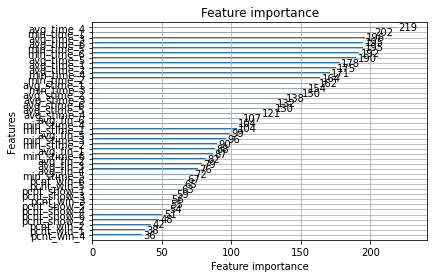

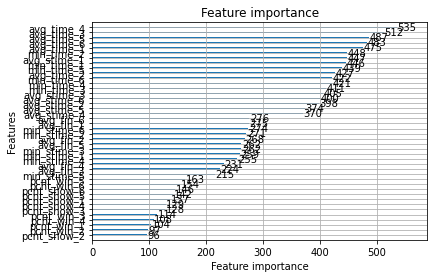

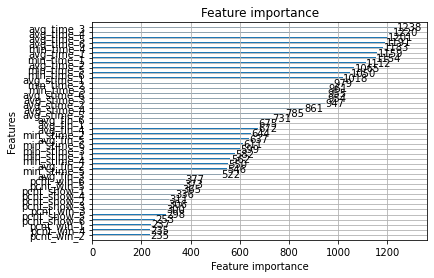

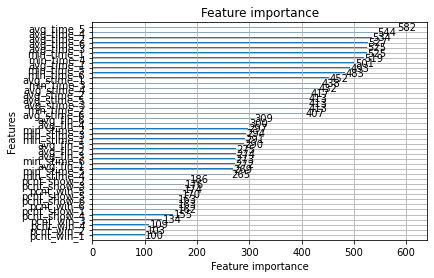

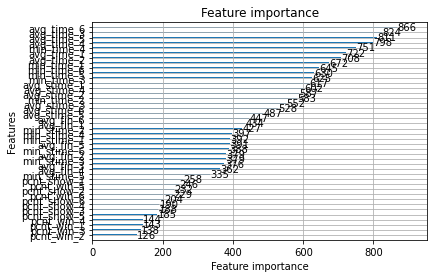

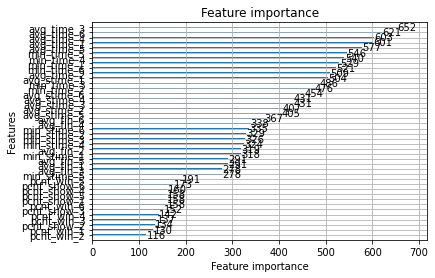

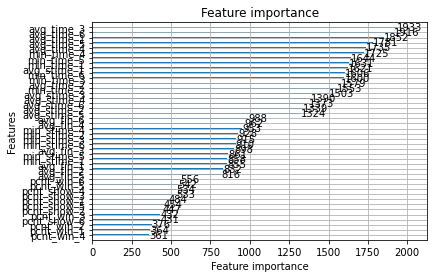

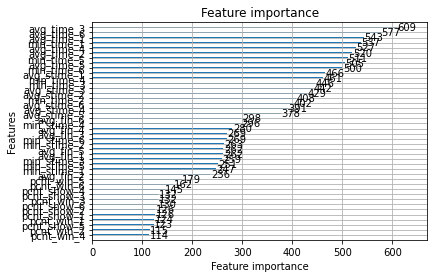

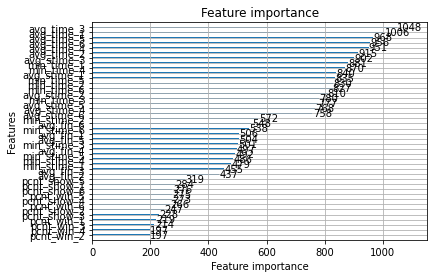

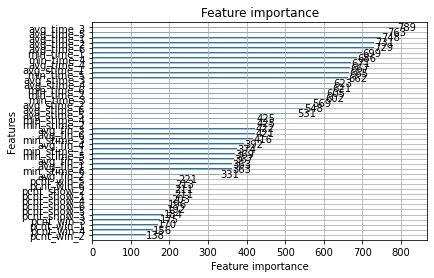

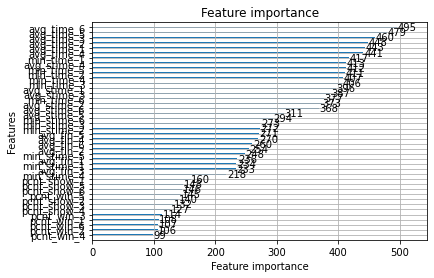

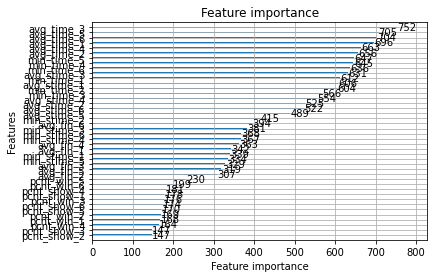

In [5]:
results = {}
results['final_solution'] = modelling(modelling_data.drop(drop_cols, axis = 1),
                                      method = 'tune', 
                                      nfold = 3, 
                                      training_months = 150, 
                                      feature_importance = True,
                                      test_start = 2019,
                                      test_end = 2020)

In [6]:
results_df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['Model Accuracy', 'Benchmark', 'Races', 'Features', 'Training Time (s)'])
results_df.drop('Features', axis = 1)

,Model Accuracy,Benchmark,Races,Training Time (s)
final_solution,0.193939,0.308734,2805,8511.145714
